In [1]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.7 MB/s eta 0:00:00


In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from deepxde.backend import tf
import shutil
import os

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



# Import Dataset and Feed to the Model

In [5]:
import pandas as pd
df = pd.read_csv('sbm10.csv', header=None)

observe = {}
observe['t'] = df[df.columns[0]].values.reshape((-1, 1))

for i in range(1,11,1):
  observe['u'+str(i)] = df[df.columns[i]].values.reshape((-1, 1))
  observe['v'+str(i)] = df[df.columns[n+i]].values.reshape((-1, 1))

In [6]:
observe_dde = {}
for i in range(1,11,1):
  observe_dde['u'+str(i)] = dde.icbc.PointSetBC(observe['t'], observe['u'+str(i)], component=i-1)
  observe_dde['v'+str(i)] = dde.icbc.PointSetBC(observe['t'], observe['v'+str(i)], component=n+i-1)

# Formulation of the Problem

We train on a series of 10 blocks. The system of equations can be rewritten as follows:

\begin{align*}
\dot{\bar{u}}_j &= \bar{v}_j \\
\dot{\bar{v}}_j &= \gamma_\mu^2 (\bar{u}_{j-1} - 2\bar{u}_j + \bar{u}_{j+1}) - \gamma_\lambda^2 \bar{u}_j - \frac{\gamma_\mu^2}{\xi} (\bar{f} + \bar{\theta}_j + \ln(\bar{v}_{j+1})) \\
\dot{\bar{\theta}} &= -(\bar{v}_{j+1})(\bar{\theta}_j + (1 + \epsilon) \ln(\bar{v}_{j+1}))
\end{align*}

where $\bar{u}_j$ is non-dimensional relative slip to the driving plate, $\bar{v}_j$ is the non-dimensional slip rate, and $\bar{\theta}_j$ is a scaled non-dimensional state variable of $j$th block. $\gamma_\mu$ and $\gamma_\lambda$ represents the stiffness of spring connecting between blocks and leaf spring, respectively. $\xi$ is non-dimensional spring constant. $\bar{f}$ is the scaled steady-state friction coefficient. Our goal is to predict parameter $\epsilon$ and $\bar{\theta}$, given the measurements of $\bar{u}_j$ and $\bar{v}_j$.


In [3]:
horizontal = 0.5      # gamma_mu
vertical = 0.2**0.5   # gamma_lambda
psi = 0.5
f = 3.2
n = 10                # number of blocks

In [8]:
def ode_system(x, y):

  u = y[:,0:10]
  v = y[:,10:20]
  theta = y[:,20:30]

  du_t = {}
  dv_t = {}
  dt_t = {}

  f_loss = []

  for m in range(n):
    du_t[str(m)] = dde.grad.jacobian(y, x, i=m)
    dv_t[str(m)] = dde.grad.jacobian(y, x, i=n+m)
    dt_t[str(m)] = dde.grad.jacobian(y, x, i=2*n+m)

  for p in range(n):
    loss_temp1 = du_t[str(p)] - y[:,n+p:n+p+1]
    f_loss.append(loss_temp1)

  loss_v1 = dv_t['0'] - horizontal**2*(-y[:,0:1]+y[:,1:2])+vertical**2*y[:,0:1]+(horizontal**2/psi)*tf.sign(y[:,n:n+1]+1)*(f+(y[:,2*n:2*n+1])+tf.log(tf.abs(y[:,n:n+1]+1)))
  loss_vn = dv_t[str(n-1)] - horizontal**2*(y[:,n-2:n-1]-y[:,n-1:n])+vertical**2*y[:,n-1:n]+(horizontal**2/psi)*tf.sign(y[:,2*n-1:2*n]+1)*(f+(y[:,3*n-1:3*n])+tf.log(tf.abs(y[:,2*n-1:2*n]+1)))
  f_loss.append(loss_v1)
  f_loss.append(loss_vn)

  for q in range(1,n-1,1):
    loss_temp2 = dv_t[str(q)] - horizontal**2*(y[:,q-1:q]-2*y[:,q:q+1]+y[:,q+1:q+2])+vertical**2*y[:,q:q+1]+(horizontal**2/psi)*tf.sign(y[:,n+q:n+q+1]+1)*(f+(y[:,2*n+q:2*n+q+1])+tf.log(tf.abs(y[:,n+q:n+q+1]+1)))
    f_loss.append(loss_temp2)

  loss_t1 = dt_t['0'] + (tf.abs(y[:,10:11]+1))*(y[:,20:21]+(1+eps_0)*tf.log(tf.abs(y[:,10:11]+1)))
  loss_t2 = dt_t['1'] + (tf.abs(y[:,11:12]+1))*(y[:,21:22]+(1+eps_1)*tf.log(tf.abs(y[:,11:12]+1)))
  loss_t3 = dt_t['2'] + (tf.abs(y[:,12:13]+1))*(y[:,22:23]+(1+eps_2)*tf.log(tf.abs(y[:,12:13]+1)))
  loss_t4 = dt_t['3'] + (tf.abs(y[:,13:14]+1))*(y[:,23:24]+(1+eps_3)*tf.log(tf.abs(y[:,13:14]+1)))
  loss_t5 = dt_t['4'] + (tf.abs(y[:,14:15]+1))*(y[:,24:25]+(1+eps_4)*tf.log(tf.abs(y[:,14:15]+1)))
  loss_t6 = dt_t['5'] + (tf.abs(y[:,15:16]+1))*(y[:,25:26]+(1+eps_5)*tf.log(tf.abs(y[:,15:16]+1)))
  loss_t7 = dt_t['6'] + (tf.abs(y[:,16:17]+1))*(y[:,26:27]+(1+eps_6)*tf.log(tf.abs(y[:,16:17]+1)))
  loss_t8 = dt_t['7'] + (tf.abs(y[:,17:18]+1))*(y[:,27:28]+(1+eps_7)*tf.log(tf.abs(y[:,17:18]+1)))
  loss_t9 = dt_t['8'] + (tf.abs(y[:,18:19]+1))*(y[:,28:29]+(1+eps_8)*tf.log(tf.abs(y[:,18:19]+1)))
  loss_t10 = dt_t['9'] + (tf.abs(y[:,19:20]+1))*(y[:,29:30]+(1+eps_9)*tf.log(tf.abs(y[:,19:20]+1)))

  f_loss.append(loss_t1)
  f_loss.append(loss_t2)
  f_loss.append(loss_t3)
  f_loss.append(loss_t4)
  f_loss.append(loss_t5)
  f_loss.append(loss_t6)
  f_loss.append(loss_t7)
  f_loss.append(loss_t8)
  f_loss.append(loss_t9)
  f_loss.append(loss_t10)

  return f_loss



# Compile and Train Model

We define time domain from 0 to 100 in `geom`. We use 5 layers of 32 neurons, 20000 residual points, 60000 iterations. $\epsilon$ for all blocks is initialized as 0.2. True $\epsilon$ is 0.5 for the first and last 3 blocks and -0.5 for the middle 4 blocks.

In [4]:
geom = dde.geometry.TimeDomain(0, 100)

Compiling model...
Building feed-forward neural network...
'build' took 0.076038 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 6.186232 s

Training model...

Step      Train loss                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Test loss                                                                                                                                                                                                                                                                                                                                                                                                                                               

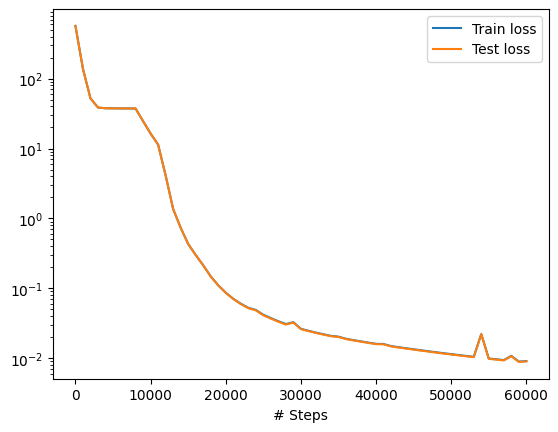

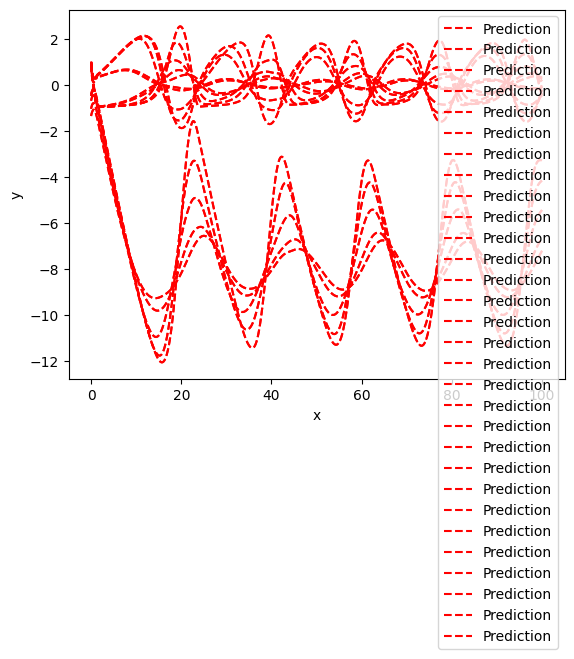

In [9]:
unit = 32
epoch = 60000
learning_rate = 0.0001
layer = 5
num_res = 20000

OUT_STEPS = 10

multi_val_performance = {}
multi_performance = {}

eps_0 = dde.Variable(0.2)
eps_1 = dde.Variable(0.2)
eps_2 = dde.Variable(0.2)
eps_3 = dde.Variable(0.2)
eps_4 = dde.Variable(0.2)
eps_5 = dde.Variable(0.2)
eps_6 = dde.Variable(0.2)
eps_7 = dde.Variable(0.2)
eps_8 = dde.Variable(0.2)
eps_9 = dde.Variable(0.2)

resultList = list(observe_dde.values())

data = dde.data.PDE(geom, ode_system, resultList, num_res, 0, num_test = 3000, anchors=observe['t'])
layer_size = [1] + [unit] * layer + [30]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)
# net.apply_output_transform(output_transform)
model = dde.Model(data, net)
model.compile("adam", lr=learning_rate, external_trainable_variables=[eps_0, eps_1, eps_2, eps_3, eps_4, eps_5, eps_6, eps_7, eps_8, eps_9])
checker = dde.callbacks.ModelCheckpoint(
    "model/model.ckpt", save_better_only=True, period=500
)
variable = dde.callbacks.VariableValue(
  [eps_0, eps_1, eps_2, eps_3, eps_4, eps_5, eps_6, eps_7, eps_8, eps_9], period=600, filename="variables.dat"
)
losshistory, train_state = model.train(iterations=epoch , callbacks=[variable, checker])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Prediction and Plotting

In [10]:
t = np.linspace(0,100,1000).reshape(-1,1)
yhat = model.predict(observe['t'])

Text(0.5, 1.0, 'Slip of 5th block')

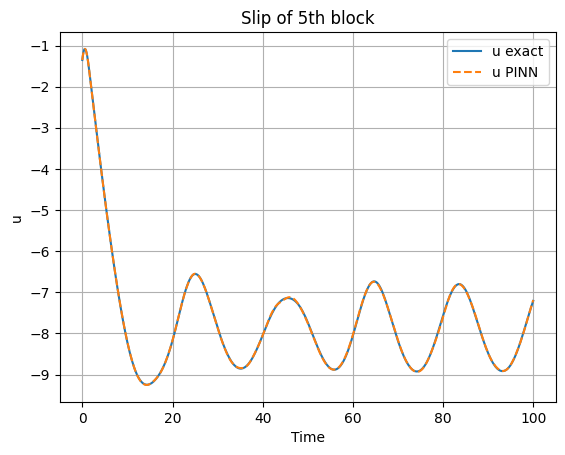

In [12]:
plt.figure()
plt.plot(observe['t'], observe['u'+str(5)], "-", label="u exact")
plt.plot(observe['t'], yhat[:, 4:5], "--", label="u PINN")
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('u')
plt.title('Slip of 5th block')

Text(0.5, 1.0, 'Slip Rate of 5th block')

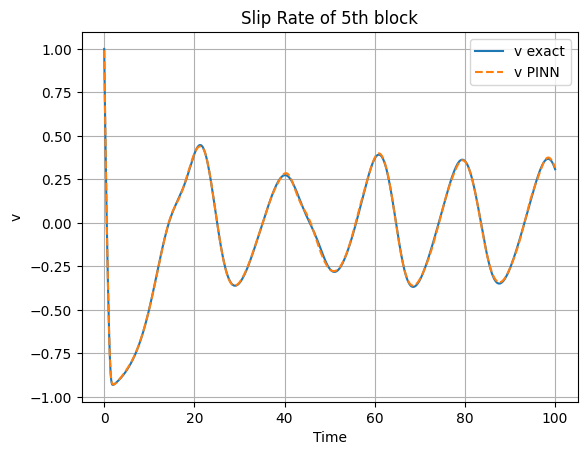

In [13]:
plt.figure()
plt.plot(observe['t'], observe['v'+str(5)], "-", label="v exact")
plt.plot(observe['t'], yhat[:, 14:15], "--", label="v PINN")
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('v')
plt.title('Slip Rate of 5th block')

Text(0.5, 1.0, 'State Variable of 5th block')

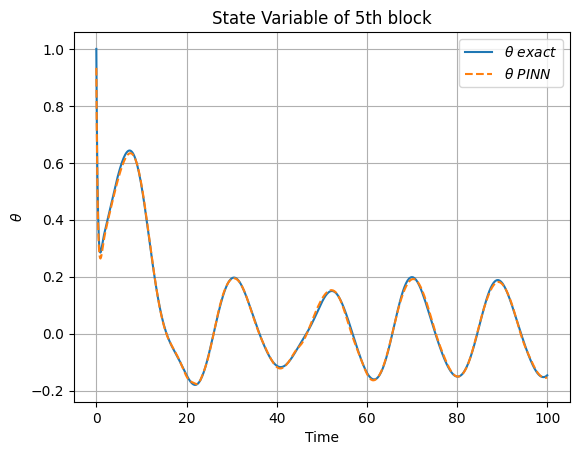

In [15]:
for i in range(1,11,1):
  observe['t'+str(i)] = df[df.columns[2*n+i]].values.reshape((-1, 1))
plt.figure()
plt.plot(observe['t'], observe['t'+str(5)], "-", label=r"${\theta\ exact}$")
plt.plot(observe['t'], yhat[:, 24:25], "--", label=r"${\theta\ PINN}$")
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel(r'$\theta$')
plt.title('State Variable of 5th block')